<a href="https://colab.research.google.com/github/siddhm11/GammaHadron/blob/main/airbnb_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip archive.zip


Archive:  archive.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


Rows: 48895 | Cols: 17 | Median price: 106.0

● SQL:
 
SELECT neighbourhood_group, COUNT(*) listings, AVG(price) avg_price
FROM airbnb
GROUP BY neighbourhood_group
ORDER BY avg_price DESC;



,neighbourhood_group,listings,avg_price
0,Manhattan,21661,196.875814
1,Brooklyn,20104,124.383207
2,Staten Island,373,114.812332
3,Queens,5666,99.517649
4,Bronx,1091,87.496792



● SQL:
 
SELECT neighbourhood_group, room_type, ROUND(AVG(price),2) avg_price
FROM airbnb
WHERE minimum_nights < 365            -- filter out long-term rentals
GROUP BY neighbourhood_group, room_type
ORDER BY avg_price DESC
LIMIT 10;



,neighbourhood_group,room_type,avg_price
0,Manhattan,Entire home/apt,249.34
1,Brooklyn,Entire home/apt,178.32
2,Staten Island,Entire home/apt,174.27
3,Queens,Entire home/apt,145.98
4,Bronx,Entire home/apt,127.51



● SQL:
 
SELECT strftime('%Y', last_review) yr, COUNT(*) reviews
FROM airbnb
WHERE last_review IS NOT NULL
GROUP BY yr
ORDER BY yr;



,yr,reviews
0,2011,7
1,2012,25
2,2013,48
3,2014,199
4,2015,1393


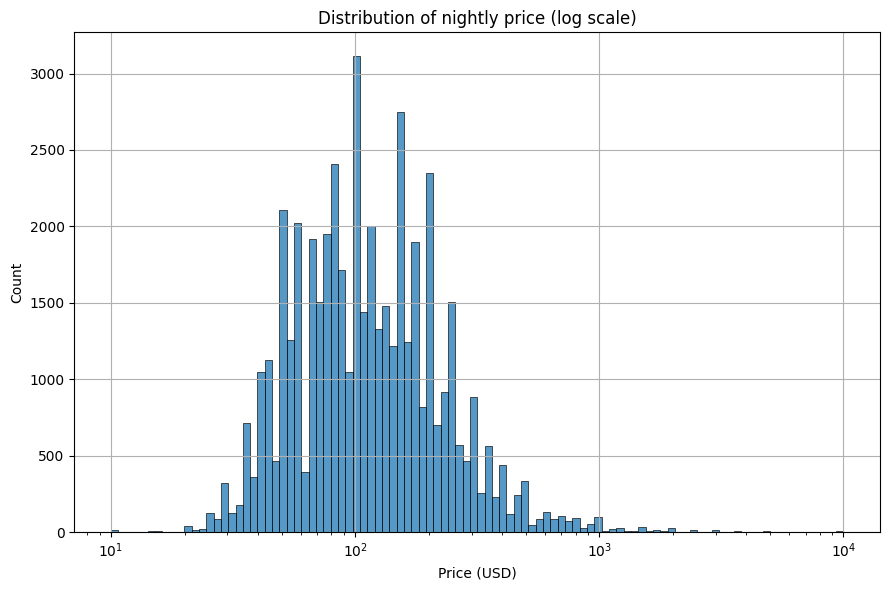

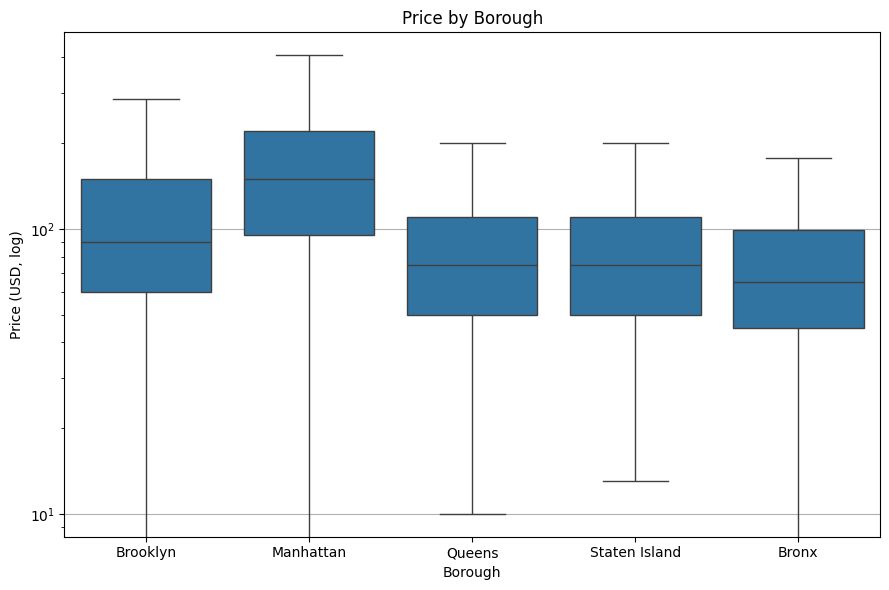

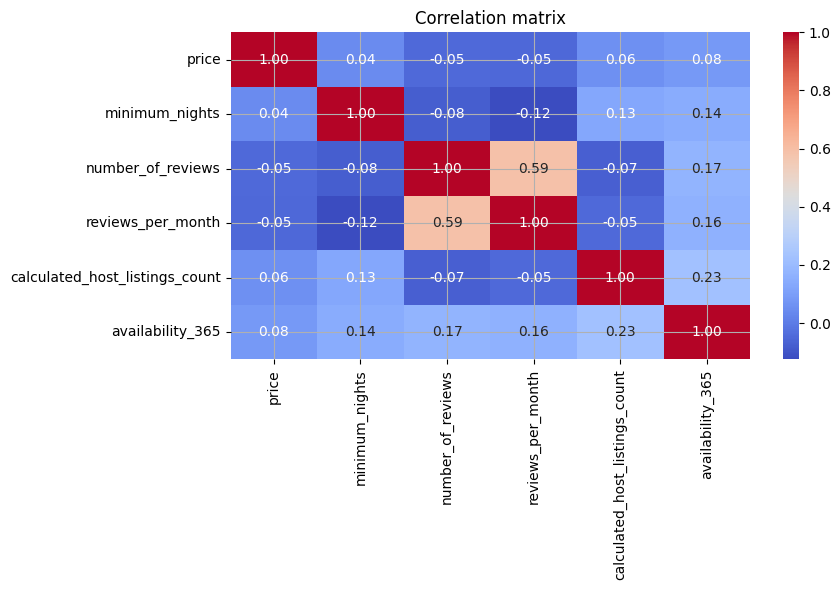

Folium map saved → airbnb_map.html
Dash app written → dash_app.py  (run:  python dash_app.py )

Model metrics  (high-price ≥ $106)
Accuracy : 0.808
Precision: 0.807
Recall   : 0.810
F1       : 0.809
ROC-AUC  : 0.875


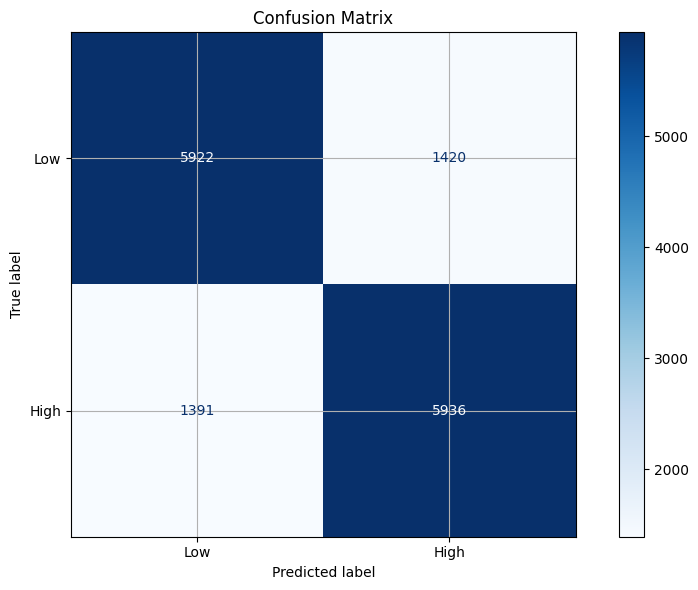

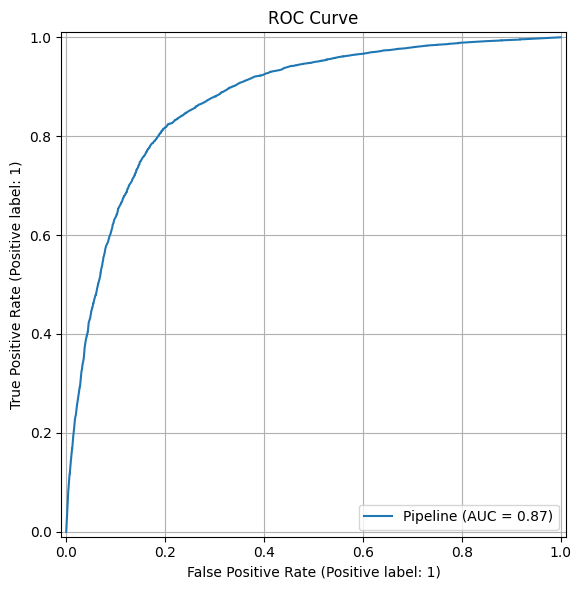

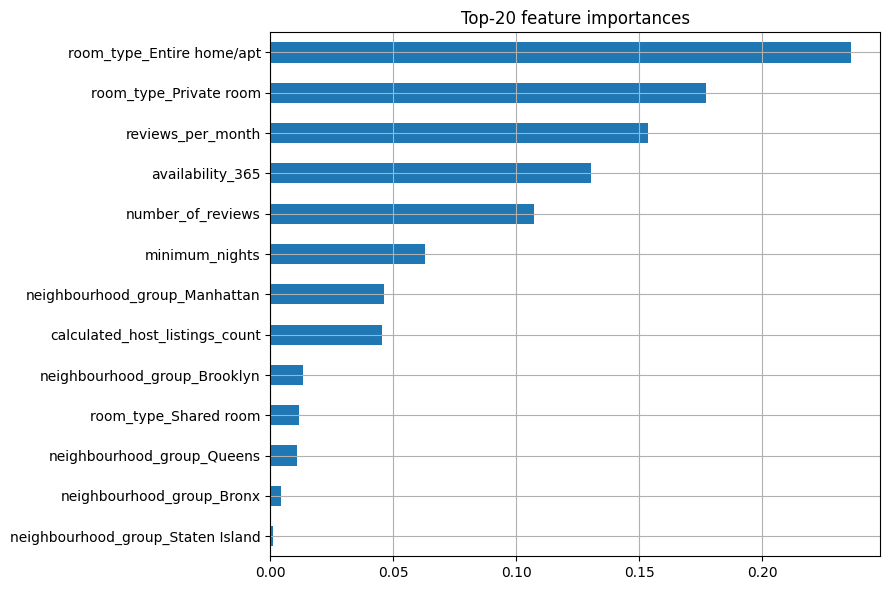

Model saved → airbnb_price_rf.pkl
\nPipeline complete!  • PNGs & HTML ready for slides  • Dash app ready.


In [3]:
# ---------------------------------------------------------------------------
# CAPSTONE PRESENTATION PIPELINE
# Dataset : NYC Airbnb Open-Data   (≈49 K listings, has geo coords & prices)
# URL     : https://raw.githubusercontent.com/dgomonov/new-york-city-airbnb-open-data/master/AB_NYC_2019.csv
# Requirements (pip): pandas, numpy, matplotlib, seaborn, folium, plotly,
#                     dash, dash-bootstrap-components, scikit-learn, sqlite3
# ---------------------------------------------------------------------------

#############################################################################
# 1. Imports & configuration
#############################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import sqlite3, os, json, pickle, warnings, textwrap, itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier

# Make plots bigger & cleaner
plt.rcParams.update({"figure.figsize": (9,6), "axes.grid": True})
warnings.filterwarnings("ignore")

#############################################################################
# 2. Data Load & Wrangle
#############################################################################
url = ("https://raw.githubusercontent.com/dgomonov/new-york-city-airbnb-open-data/"
       "master/AB_NYC_2019.csv")
df  = pd.read_csv("/content/AB_NYC_2019.csv")

# Basic cleaning
df.drop_duplicates(subset=["id"], inplace=True)
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

# Handle minimal missing: fill reviews/month and reviews/number w/ 0
for col in ["reviews_per_month", "number_of_reviews"]:
    df[col] = df[col].fillna(0)

# Target label: listings priced above dataset median
price_median          = df["price"].median()
df["high_price_flag"] = (df["price"] > price_median).astype(int)

print("Rows:", df.shape[0], "| Cols:", df.shape[1], "| Median price:", price_median)

#############################################################################
# 3. Persist to SQLite & run SQL-powered EDA
#############################################################################
db_path = "airbnb_nyc.sqlite"
if os.path.exists(db_path): os.remove(db_path)
conn = sqlite3.connect(db_path)
df.to_sql("airbnb", conn, index=False)

def run_sql(q):
    print("\n● SQL:\n", q)
    res = pd.read_sql_query(q, conn)
    display(res.head())
    return res

# Example SQL queries (copy output to slides)
q1 = """
SELECT neighbourhood_group, COUNT(*) listings, AVG(price) avg_price
FROM airbnb
GROUP BY neighbourhood_group
ORDER BY avg_price DESC;
"""
neigh_stats = run_sql(q1)

q2 = """
SELECT neighbourhood_group, room_type, ROUND(AVG(price),2) avg_price
FROM airbnb
WHERE minimum_nights < 365            -- filter out long-term rentals
GROUP BY neighbourhood_group, room_type
ORDER BY avg_price DESC
LIMIT 10;
"""
top10 = run_sql(q2)

q3 = """
SELECT strftime('%Y', last_review) yr, COUNT(*) reviews
FROM airbnb
WHERE last_review IS NOT NULL
GROUP BY yr
ORDER BY yr;
"""
reviews_by_year = run_sql(q3)

#############################################################################
# 4. EDA visualisations (Matplotlib/Seaborn) – save PNGs for slides
#############################################################################
# (i) Distribution of price
sns.histplot(df["price"], bins=100, log_scale=True)
plt.title("Distribution of nightly price (log scale)"); plt.xlabel("Price (USD)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("price_dist.png"); plt.show()

# (ii) Price by neighbourhood group (boxplot)
sns.boxplot(x="neighbourhood_group", y="price", data=df, showfliers=False)
plt.yscale("log"); plt.title("Price by Borough"); plt.xlabel("Borough"); plt.ylabel("Price (USD, log)")
plt.tight_layout(); plt.savefig("price_by_borough.png"); plt.show()

# (iii) Correlation heat-map of numeric vars
num_cols = ["price","minimum_nights","number_of_reviews","reviews_per_month",
            "calculated_host_listings_count","availability_365"]
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix"); plt.tight_layout(); plt.savefig("corr_heatmap.png"); plt.show()

#############################################################################
# 5. Interactive Folium map (saved as HTML for slides/demo)
#############################################################################
sample = df.sample(3000, random_state=42)  # 3 K pts keeps map responsive
m = folium.Map(location=[40.75, -73.98], zoom_start=11, tiles="CartoDB positron")
cluster = MarkerCluster().add_to(m)

color_map = {
    "Manhattan": "red", "Brooklyn": "blue",
    "Queens": "green", "Bronx": "purple", "Staten Island": "orange"
}

for _, row in sample.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color_map.get(row["neighbourhood_group"], "gray"),
        fill=True, fill_opacity=0.6,
        tooltip=f"${row['price']} · {row['room_type']}"
    ).add_to(cluster)

map_path = "airbnb_map.html"
m.save(map_path)
print("Folium map saved →", map_path)

#############################################################################
# 6. Plotly Dash dashboard (run separately via CLI)
#############################################################################
dash_code = """
# ---- save this as dash_app.py  -------------------------------------------
import dash, dash_bootstrap_components as dbc
from dash import html, dcc, Input, Output
import plotly.express as px
import pandas as pd

df = pd.read_csv('AB_NYC_2019.csv')
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.COSMO])

app.layout = dbc.Container([
    html.H2("NYC Airbnb Explorer"),
    dbc.Row([
        dbc.Col([
            html.Label("Neighbourhood group"),
            dcc.Dropdown(options=[{'label':b,'value':b} for b in sorted(df.neighbourhood_group.unique())],
                         value=['Manhattan','Brooklyn'], multi=True, id='neigh_dd')
        ], md=4),
        dbc.Col([
            html.Label("Max price"),
            dcc.Slider(id='price_slider', min=0, max=500, step=10, value=250,
                       marks={0:'0',100:'100',200:'200',300:'300',400:'400',500:'500+'})
        ], md=8)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='map_scatter'), md=6),
        dbc.Col(dcc.Graph(id='room_hist'), md=6)
    ])
], fluid=True)

@app.callback(
    Output('map_scatter','figure'),
    Output('room_hist','figure'),
    Input('neigh_dd','value'),
    Input('price_slider','value')
)
def update_graph(neighs, max_price):
    dff = df[(df.neighbourhood_group.isin(neighs)) & (df.price <= max_price)]
    fig_map = px.scatter_mapbox(
        dff, lat='latitude', lon='longitude', color='neighbourhood_group',
        hover_data=['price','room_type'], zoom=10, height=500)
    fig_map.update_layout(mapbox_style='carto-positron', margin=dict(t=0,l=0,r=0,b=0))

    fig_hist = px.histogram(dff, x='room_type', color='neighbourhood_group',
                            barmode='group', height=500)
    return fig_map, fig_hist

if __name__ == "__main__":
    app.run_server(debug=True)
# -------------------------------------------------------------------------
"""
with open("dash_app.py", "w") as f: f.write(dash_code)
print("Dash app written → dash_app.py  (run:  python dash_app.py )")

#############################################################################
# 7. Classification Model
#############################################################################
features   = ["neighbourhood_group","room_type","minimum_nights",
              "number_of_reviews","reviews_per_month",
              "calculated_host_listings_count","availability_365"]
X          = df[features]
y          = df["high_price_flag"]

cat_feats  = ["neighbourhood_group","room_type"]
num_feats  = list(set(features) - set(cat_feats))

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats),
    ("num", Pipeline([("scaler", StandardScaler())]), num_feats)
])

model = RandomForestClassifier(n_estimators=200, random_state=0)

pipe = Pipeline([("prep", preprocess), ("clf", model)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

pipe.fit(X_train, y_train)
y_pred  = pipe.predict(X_test)
y_prob  = pipe.predict_proba(X_test)[:,1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print(f"\nModel metrics  (high-price ≥ ${price_median:.0f})")
for n,v in zip(["Accuracy","Precision","Recall","F1","ROC-AUC"],
               [acc,prec,rec,f1,auc]):
    print(f"{n:9}: {v:0.3f}")

# Confusion matrix
cm_disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test,
                                                display_labels=["Low","High"],
                                                cmap="Blues")
plt.title("Confusion Matrix"); plt.tight_layout(); plt.savefig("conf_matrix.png"); plt.show()

# ROC curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title("ROC Curve"); plt.tight_layout(); plt.savefig("roc_curve.png"); plt.show()

# Feature importance
# Grab one fitted RF from inside the pipeline
rf = pipe.named_steps["clf"]
ohe = pipe.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_feats)
feat_names = np.r_[cat_names, num_feats]
importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)[:20]
importances.plot(kind="barh")
plt.gca().invert_yaxis(); plt.title("Top-20 feature importances"); plt.tight_layout()
plt.savefig("feature_importance.png"); plt.show()

#############################################################################
# 8. Persist model if you wish
#############################################################################
with open("airbnb_price_rf.pkl", "wb") as f: pickle.dump(pipe, f)
print("Model saved → airbnb_price_rf.pkl")

#############################################################################
# 9. END --------------------------------------------------------------------
print("\\nPipeline complete!  • PNGs & HTML ready for slides  • Dash app ready.")
